In [3]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [9]:
from auto_encoder import AutoEncoder
from masked_dataset import CIFAR10DataModule
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

In [3]:
batch_size = 8
cifar10 = CIFAR10DataModule(batch_size=batch_size)
cifar10.setup("nothing")
cifar10_train = cifar10.train_dataloader()

in_channel_size = 3
num_epochs = 10
model = AutoEncoder(in_channel_size=3)
model.cuda()
model.eval()

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

checkpoint = torch.load(
    "lightning_logs/version_1/checkpoints/last.ckpt", map_location=device)
model.load_state_dict(checkpoint["state_dict"])


Found cached dataset cifar10 (/home/jovyan/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

<All keys matched successfully>

In [4]:
original_size = 224*224

mseloss = nn.MSELoss(reduction="none")
weights = torch.zeros([original_size, original_size], dtype=torch.bfloat16).cpu()
times_this_index_is_sampled = torch.zeros(original_size)

In [5]:
torch.cuda.empty_cache()

In [6]:
from tqdm.notebook import tqdm

In [7]:
%%time
for batch_idx, (masked, full, indices) in enumerate(tqdm(cifar10_train)):
    masked = masked.cuda()
    full = full.cuda()
    # pass the sampled data to the model
    prediction = model(masked)
    # go through each image in the current batch
    for i in range(batch_size):
        # get loss per pixel across all channels
        loss = mseloss(prediction[i], full[i])
        single_loss = torch.sum(loss, dim=0)
        # get the indices that were in the sample
        idxs = indices[i]
        # add the losses to the index's loss tracker
        # iterate the number of samples seen
        weights[idxs] += single_loss.detach().cpu()
        times_this_index_is_sampled[idxs] += 1

  0%|          | 0/5625 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [8]:
torch.save(weights, "weights.pth")

# total loss / number of times seen
weights /= times_this_index_is_sampled

torch.save(weights, "divided.pth")

# normalize across rows
weights = F.normalize(weights, dim=0)

torch.save(weights, "embedding_tensor.pth")

In [5]:
weights = torch.load("embedding_tensor.pth")

In [6]:
weights

tensor([[0.0157, 0.0092, 0.0032,  ..., 0.0432, 0.0403, 0.0442],
        [0.0115, 0.0058, 0.0011,  ..., 0.0427, 0.0400, 0.0435],
        [0.0150, 0.0039, 0.0025,  ..., 0.0442, 0.0452, 0.0481],
        ...,
        [0.0500, 0.0503, 0.0439,  ..., 0.0016, 0.0020, 0.0082],
        [0.0510, 0.0525, 0.0461,  ..., 0.0010, 0.0066, 0.0298],
        [0.0474, 0.0486, 0.0420,  ..., 0.0030, 0.0091, 0.0238]],
       dtype=torch.bfloat16)

In [7]:
weights.shape

torch.Size([50176, 50176])

In [10]:
weights_np = np.array(weights.type(torch.float16))

In [12]:
np.save("weights.np", weights_np)

In [13]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [20]:
weights_np = np.array(weights.type(torch.float16))

In [1]:
weights_np

NameError: name 'weights_np' is not defined

In [ ]:
tsne = TSNE(n_jobs=4)
Y = tsne.fit_transform(weights_np)

In [3]:
#from fastTSNE import TSNE
import numpy as np

In [5]:
weights_np = np.load("weights.np.npy.bak")

In [16]:
weights_np.shape

(50176, 50176)

In [3]:
from fastTSNE.callbacks import ErrorLogger

In [5]:
weights_smaller = weights_np[:1000,:1000]

In [6]:
weights_smaller.shape

(1000, 1000)

In [6]:
from sklearn.manifold import TSNE

In [9]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=64)
x_new = pca.fit_transform(weights_np)

In [ ]:
pca

In [7]:
X_embedded = TSNE(n_components=64, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(weights_np)

ValueError: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.

In [9]:
X_embedded[:,0].shape

(50176,)

In [20]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt

In [18]:
np.save("full_matrix_64_pca", x_new)

In [20]:
x_new.shape

(50176, 64)

In [10]:
X_embedded

array([[ 1.97897930e+01],
       [ 1.94913998e+01],
       [ 1.73698750e+01],
       [ 1.73764515e+01],
       [ 2.04687920e+01],
       [ 1.95192966e+01],
       [ 1.94760818e+01],
       [ 2.02523251e+01],
       [ 1.94711456e+01],
       [ 1.72406063e+01],
       [ 1.74610596e+01],
       [ 2.05672989e+01],
       [ 1.70021496e+01],
       [ 1.68053894e+01],
       [ 2.05850601e+01],
       [ 1.86511955e+01],
       [ 1.65800228e+01],
       [ 1.81945457e+01],
       [ 2.06968250e+01],
       [ 1.87539635e+01],
       [ 1.86253376e+01],
       [ 1.84925632e+01],
       [ 1.94888000e+01],
       [ 1.82617607e+01],
       [ 2.06820736e+01],
       [ 1.60902920e+01],
       [ 1.54819527e+01],
       [ 1.82415733e+01],
       [ 1.61765099e+01],
       [ 1.54494219e+01],
       [ 1.56256590e+01],
       [ 1.56606665e+01],
       [ 1.60742359e+01],
       [ 1.25607147e+01],
       [ 1.36579304e+01],
       [ 1.60538673e+01],
       [ 1.50865459e+01],
       [ 1.38806505e+01],
       [ 1.2

In [2]:
X_embedded = np.load("full_matrix.npy")

In [18]:
li = list(zip(range(1, len(X_embedded[:1000])), X_embedded[:1000,0]))

In [19]:
li

[(1, 24.868246),
 (2, 56.1222),
 (3, -30.259628),
 (4, -20.730776),
 (5, 54.935432),
 (6, -22.91074),
 (7, 55.99854),
 (8, 54.891674),
 (9, 7.0782743),
 (10, -68.5755),
 (11, -51.750813),
 (12, 62.599033),
 (13, -30.449211),
 (14, -51.78252),
 (15, 56.14776),
 (16, -51.841274),
 (17, -27.878304),
 (18, -25.62972),
 (19, 6.0573483),
 (20, 8.079597),
 (21, -2.779214),
 (22, 31.734362),
 (23, 34.91294),
 (24, 31.616741),
 (25, 66.74493),
 (26, -51.77105),
 (27, 7.3497286),
 (28, -51.824406),
 (29, 29.937065),
 (30, -25.71967),
 (31, -51.787598),
 (32, -51.78371),
 (33, -68.59737),
 (34, 55.975857),
 (35, 7.324223),
 (36, -51.768055),
 (37, -51.825912),
 (38, -25.741222),
 (39, 44.959526),
 (40, 4.648669),
 (41, 7.3004575),
 (42, 34.92138),
 (43, -79.94339),
 (44, 7.2215877),
 (45, -51.82589),
 (46, 54.905838),
 (47, 8.108716),
 (48, 45.012047),
 (49, 7.364088),
 (50, -43.31272),
 (51, -68.517265),
 (52, 31.725328),
 (53, 45.01325),
 (54, 45.170143),
 (55, 66.76199),
 (56, -51.80386),
 (57

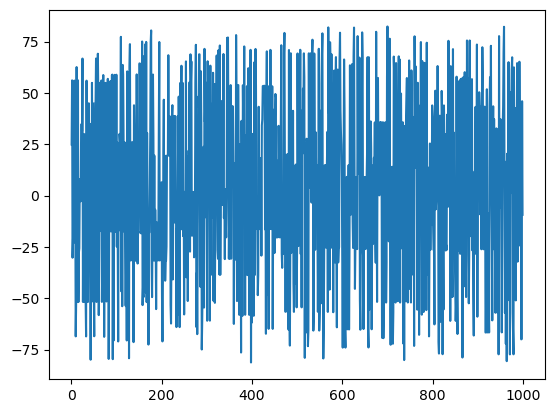

In [20]:
plt.plot(*zip(*li))

In [4]:
# from sklearn import datasets

tsne = TSNE(callbacks=ErrorLogger(), callbacks_every_iters=1,
n_components=64,  neighbors='approx', negative_gradient_method='fft')


embedding = tsne.fit(weights_np)

/opt/conda/envs/tsne/lib/python3.7/site-packages/numba/core/typed_passes.py:330: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../opt/conda/envs/tsne/lib/python3.7/site-packages/fastTSNE/pynndescent/rp_trees.py", line 21:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/conda/envs/tsne/lib/python3.7/site-packages/fastTSNE/pynndescent/pynndescent_.py:133: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../.

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [ ]:
embedding